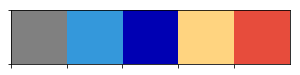

In [1]:
import random
from six.moves import cPickle as pickle
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.patches import Circle
rc('text', usetex=True)
rc('text.latex', preamble='\\usepackage{color}')
from PIL import Image
import numpy as np
from scipy.misc import comb
from math import log, exp, sqrt
from collections import Counter
import seaborn as sns
sns.set_context("paper")
# sns.set_context('talk')
import string
import json
import pickle
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
COLORS = ["#808080", "#3498db", "#0000b3", "#ffd480", "#e74c3c"]
sns.palplot(sns.color_palette(COLORS))

## word neighbors

In [341]:
# Constants
itow = json.load(open('../data/coco/cocotalk.json', 'r'))['ix_to_word']
WORDS = {int(k): v for k, v in itow.items()}
if 0 not in WORDS:
    WORDS[0] = 'EOS'
MATCH = {v: k for k,v in WORDS.items()}
del itow
FF = pickle.load(open('../data/coco/idf_coco_01.pkl', 'rb'))
F = pickle.load(open('cooc_freq.pkl', 'rb'))[0]

# utils:
def normalize(A):
    l1 = A.sum(axis=1)
    A /= l1.reshape(len(A), 1)
    return A

def invocab(ngram):
    for w in ngram:
        if w not in MATCH:
            return False
    return True

def space(xy, points, delta=1):
    x , y = xy
    xs = np.array([p[0] for p in points])
    ys = np.array([p[1] for p in points])
    while np.any(np.absolute(xs -x) < delta):
        x += delta
    while np.any(np.absolute(ys -y) < delta):
        y += delta
    return [x, y]

def exps(sim, tau=0.2, freq=False):
    if freq:
        return normalize(np.exp((sim-1 - tau * FF)/tau))
    else:
        return normalize(np.exp((sim-1)/tau))
    
sim_wiki = pickle.load(open('../data/Glove/glove_wiki_d300_w15_similarities.pkl',
                             'rb'), encoding='iso-8859-1')
sim_coco = pickle.load(open('../data/Glove/glove_coco_d300_w15_similarities.pkl','rb'))
G2_coco = pickle.load(open('../data/Glove/glove_coco_d300_w15_matrix_tsne2D.pkl', 'rb'))
G2 = pickle.load(open('../data/Glove/glove_wiki_d300_w15_matrix_tsne2D.pkl', 'rb'))


In [432]:
def cancel_proba(arr, indices):
    arr = arr.copy()
    for i in range(len(arr)):
        if i not in indices:
            arr[i] = 0
    return arr / np.sum(arr)


def plot_words_2d(ax, selected, sim, X2, NN=10, verbose=0, sens=1):
    sns.set()
    colors = sns.color_palette("Paired", NN)
    V = np.arange(sim.shape[0])
    k = MATCH[selected]
    e = 0
    coords = []
    nbrs = sim[k].argsort()[-NN:][::-1]
    wnbrs = [WORDS[i] for i in nbrs]
    p = cancel_proba(sim[k], nbrs)
    samples = np.random.choice(V, p=p, size=(50,))
    xs = X2[samples, 0]
    ys = X2[samples, 1]
    sns.kdeplot(xs, ys, ax=ax, cut=2,
                shade=False, shade_lowest=False)
    for i in nbrs:
        if i == k:
            ax.text(X2[i,0], X2[i,1], WORDS[i], fontsize=15, color="k", weight=3)
        else:
            ax.text(X2[i,0], X2[i,1], WORDS[i], fontsize=10, color="k")
    plt.tight_layout()

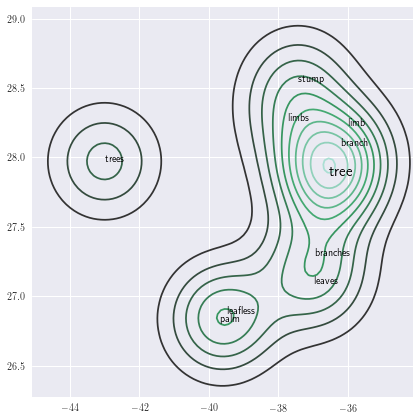

In [433]:
np.random.seed(1)
f, ax = plt.subplots(1,1, figsize=(6,6))
plot_words_2d(ax, 'tree', exps(sim_coco, tau=.15), X2=G2_coco)

In [131]:
def plot_word_neighbors(axs, selected, sim1, sim2, labels,
                        NN=10, verbose=0, legend=0):
    sns.set()
    ax2, ax = axs
    h = .05
    colors = sns.color_palette("Paired", NN)
    k = MATCH[selected]
    nbrs1 = np.flip(sim1[k].argsort()[-NN:][::-1], axis=0)
    nbrs2 = np.flip(sim2[k].argsort()[-NN:][::-1], axis=0)
    nbrs = list(set(nbrs1).union(set(nbrs2)))
    nbrs.remove(k)
    nbrs = nbrs + [k]
#     print('neighbors:', nbrs)
    wnbrs = [WORDS[i] for i in nbrs]
    simnbrs1 = [sim1[k,i] for i in nbrs]
    simnbrs2 = [sim2[k,i] for i in nbrs]
    ys = 4 / 3 * h * np.arange(len(nbrs))
    ax2.get_shared_y_axes().join(ax, ax2)
    ax2.set_xlim(1e-6, 1)
    ax2.text(1e-4,-.165,"freq", fontsize=18)
    ax2.invert_xaxis()
    ax2.yaxis.tick_right()
    freqnbrs = [F[i] for i in nbrs]
    if verbose:
        print('freq', freqnbrs)
        print('sim', simnbrs)
    ax2.barh(ys, freqnbrs, height=h,
             align='edge', color=COLORS[3])
    
    ax2.set_xscale("log", nonposx='clip')
#     ax2.set_xlabel('freq')
    
    ax2.axis('off')
    ax.barh(ys+2*h/3, [0] * (len(nbrs)-1) + [1], height=h/3,
            align='edge', color=COLORS[0], alpha=.5,
           label="MLE")
    ax.barh(ys+h/3, simnbrs1, height=h/3,
            align='edge', color=COLORS[1], alpha=.7,
           label=labels[0])
    ax.barh(ys, simnbrs2, height=h/3,
            align='edge', color=COLORS[2], alpha=.7,
            label=labels[1])
    ax.set_yticks(ys + h/2)
    ax.tick_params('y', labelsize=14)
    ax.set_yticklabels(wnbrs)
    ax.set_ylim(min(ys), max(ys) + h)
    ax.set_xlim(1e-4, 1)
    ax.set_xscale("log", nonposx='clip')
    ax.set_xlabel('$r_\\tau(y|$%s$)$' % selected)
    
    if legend:
        ax.legend(fontsize=16, loc=4)
    plt.tight_layout()
#         plt.savefig('../figures/%s_nbrs_%s.png' % (prefix, WORDS[k]),
#                     dpi=300, bbox_inches='tight')


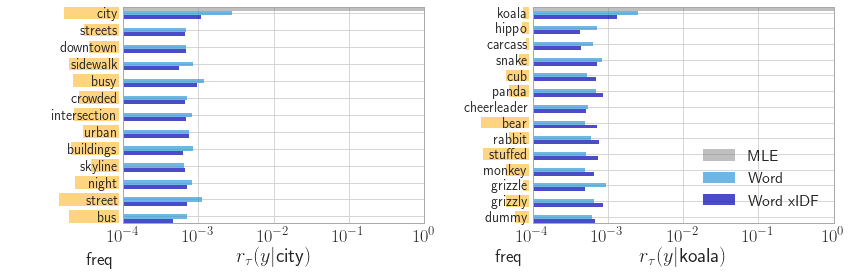

In [132]:
sns.set()
sns.set_style('whitegrid', rc={"axes.edgecolor": 'darkgray'})
sns.set_context('paper', font_scale=2.3, rc={"lines.linewidth": 2,
                                             "lines.markersize": 8})
fig, axs = plt.subplots(1, 4, figsize=(12, 4),
                        gridspec_kw = {'width_ratios':[1, 3] * 2})
word = "city" #"street"
plot_word_neighbors(axs[:2], word,
                    exps(sim_coco, 0.15),
                    exps(sim_coco, 0.15, True),
                    ['Word', 'Word xIDF'])

word = "koala" #"street"
plot_word_neighbors(axs[2:4], word,
                    exps(sim_coco, 0.15),
                    exps(sim_coco, 0.15, True),
                    ['Word', 'Word xIDF'],
                   legend=1)

fig.tight_layout()
plt.subplots_adjust(wspace=0.02)

plt.savefig('../figures/words_nbrs_coco.png',
            dpi=300, bbox_inches='tight')


In [ ]:
frequent = F.argsort()[-80:][::-1]
medium = F.argsort()[1300:1380]
rare = F.argsort()[60:90]

for fr in frequent:
    print(WORDS[fr],)

In [7]:
def skim(arr, percentile):
    th = np.percentile(arr, percentile)
    arr[arr<th] = 0
    return arr

def plot_nbrs_picks(word, ax, legend=False):
    iw = MATCH[word]
    dirac = np.zeros(sim_coco.shape[0])
    dirac[MATCH[word]] = 1
    ax.plot(dirac, c='darkred', alpha=0.5, label="MLE - $\\delta$")

    default = skim(exps(sim_coco, 0.15, False)[iw], 99.5)
    ax.plot(default, c='darkgreen', label="Tok-Reward - $r_\\tau$", alpha=.5)

    xidf = skim(exps(sim_coco, 0.15, True)[iw], 99.5)
    ax.plot(xidf, c='mediumblue', label="Tok-Reward - $r_\\tau^{IDF}$", alpha=.5)
    if legend:
        ax.legend(fontsize=15, loc=2)
    wxidf = np.nonzero(xidf)[0]
    wdef = np.nonzero(default)[0]
    wperr = 4
    sel = np.concatenate((np.array([iw]),
                          np.random.choice(wdef, wperr),
                          np.random.choice(wxidf, wperr)))
    colors = ['darkred'] + wperr * ['darkgreen'] + wperr * ['mediumblue']
    for e, (s, c) in enumerate(zip(sel, colors)):
#         print('index:', s, 'default', default[s], 'xidf', xidf[s])
        if not e:
            scale=.5
            slide = 25
            pick = 1
        else:
            if e < wperr + 1:
                pick = default[s]
                slide = -400
                scale = 5
#                 print('e:', e, WORDS[s])
            else:
                pick = xidf[s]
                slide = 100
                scale = 3

        ax.annotate(WORDS[s].encode().decode(),
                    xy=(s, pick),
                    xytext=(s + slide, scale * pick),
                    color=c,
                    fontsize=18,
    #               arrowprops=dict(facecolor='black', shrink=0.05),
                    arrowprops=dict(arrowstyle="->",
                                    connectionstyle="arc3",
                                    facecolor=c,
                                    edgecolor=c))
    ax.set_yscale("log")
    ax.set_xticks([])
    ax.set_ylabel('$r_\\tau(y|$%s$)$' % word)
#     ax.set_xlabel('$\\mathcal V$')


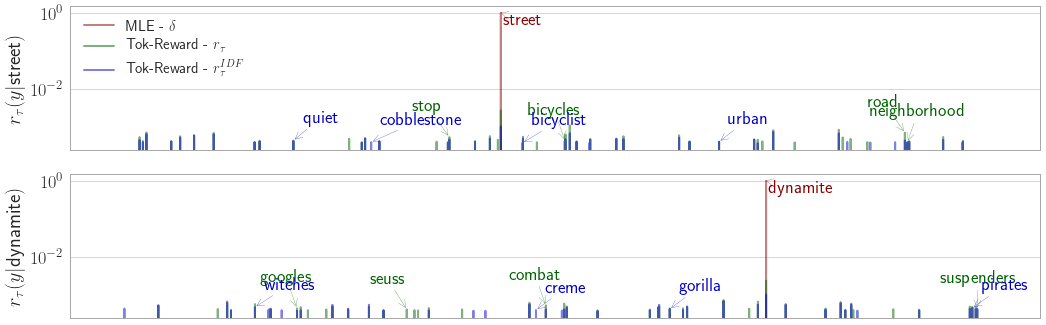

In [8]:
sns.set()
sns.set_style('whitegrid', rc={"axes.edgecolor": 'darkgray'})
sns.set_context('paper', font_scale=2.3, rc={"lines.linewidth": 2,
                                             "lines.markersize": 8})

f, axs = plt.subplots(2, 1, figsize=(15, 5))
np.random.seed(1244)
plot_nbrs_picks('street', axs[0], legend=True)

np.random.seed(17)
plot_nbrs_picks('dynamite', axs[1])

plt.tight_layout()
# plt.savefig('../figures/nbrs_picks.png',
#             dpi=300, bbox_inches='tight')

## Abstract

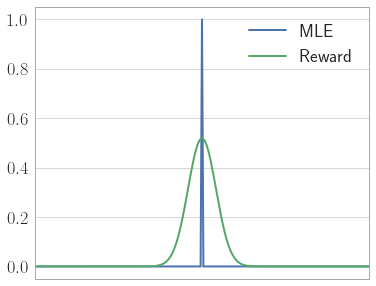

In [221]:
L = 800
x = np.arange(L)
y = np.zeros(L)
center = 300
a = 1e-5
y = 1/a * (1/np.pi * 1/(1+((x- center)/a)**2))
y /= np.sum(y)

if 0:
    centers = [center] + np.random.randint(low=1,
                                           high=L,
                                           size=10)
    sigmas = np.random.randint(low=1,
                               high=10,
                               size=10) / 10
    weights = [5] + np.random.randint(low=1,
                                      high=10,
                                      size=10)/2
    weights = weights / np.sum(weights)
    z = np.zeros(L)
    for w, c, s in zip(weights, centers, sigmas):
        z += w * np.exp(-(x-c)**2/2/s)
    # z += 1/30 * np.random.randn(50)
if 1:
    sigma = 10
    z = np.exp(-(x-center)**2/2/sigma**2)
z /= np.sum(z)
z = 13 * z
sns.set()
sns.set_style('whitegrid', rc={"axes.edgecolor": 'darkgray'})
sns.set_context('paper', font_scale=2.3, rc={"lines.linewidth": 2,
                                             "lines.markersize": 8})
plt.figure(figsize=(6,5))
plt.plot(x, y, label='MLE')
plt.plot(x, z, label='Reward')
plt.xlim([center-12*sigma, center+12*sigma])
plt.xticks([])
plt.legend()
# plt.xticks(centers, ['jungle', 'forest', 'clearing'], rotation=45)


### Sentences

In [4]:
import torch
GLOVE_PATH = '../../InferSent/dataset/GloVe/glove.840B.300d.txt'
import sys
sys.path.insert(0, '../../InferSent/encoder/')
model = torch.load('../../InferSent/encoder/infersent.allnli.pickle')
model.set_glove_path(GLOVE_PATH)
model.build_vocab_k_words(K=100000)


/home/maha/anaconda3/lib/python3.6/site-packages/torch/serialization.py:286: SourceChangeWarning: source code of class 'models.BLSTMEncoder' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


Vocab size : 100000


In [40]:
A = json.load(open('../data/coco/captions_train2014.json', 'r'))['annotations']
caps = {}
for a in A:
    if a['image_id'] in caps:
        caps[a['image_id']].append(a['caption'][:-1].lower().split())
    else:
        caps[a['image_id']] = [a['caption'][:-1].lower().split()]
del A
        
def embed_sent(sentences):
    embeddings = model.encode(sentences, bsize=128, tokenize=False, verbose=False)
    return embeddings

def alter(sentence, distance, vocab):
    sampled = sentence.copy()
    m = len(sampled)
    indices = list(range(m))
#     print('indices:', indices)
    random.shuffle(indices)
    for k in indices[:distance]:
        sampled[k] = random.choice(vocab)
    return sampled, indices[:distance]
    

In [145]:
def fold(sentence, maxlen=5):
    folds = len(sentence) // maxlen
    sent = ""
    for f in range(folds+1):
        if len(sentence) > maxlen * (f+1):
            sent += ' '.join(sentence[maxlen*f: maxlen*(f+1)]) + '\n'
        else:
            sent += ' '.join(sentence[maxlen*f:])
    return sent

def highlight(sentence, indices):
#     print('Highlighting ', sentence , '@', indices)
    sent = sentence.copy()
    for ind in indices:
        sent[ind] = '\\underline{%s}' % sent[ind]
    return sent

def sentence_bleu(hypothesis, reference, smoothing=True, order=4, **kwargs):
    log_score = 0
    if len(hypothesis) == 0:
        return 0
    for i in range(order):
        hyp_ngrams = Counter(zip(*[hypothesis[j:] for j in range(i + 1)]))
        ref_ngrams = Counter(zip(*[reference[j:] for j in range(i + 1)]))
        numerator = sum(min(count, ref_ngrams[bigram])
                        for bigram, count in hyp_ngrams.items())
        denominator = sum(hyp_ngrams.values())
        if smoothing:
            numerator += 1
            denominator += 1
        score = numerator / denominator
        if score == 0:
            log_score += float('-inf')
        else:
            log_score += log(score) / order
    bp = min(1, exp(1 - len(reference) / len(hypothesis)))
    return exp(log_score) * bp


In [50]:
def plot_sentences(ax, imids, N=2, V="refs", d=3, score="bleu", normalize=0):
    gts = []
    flatgts = []
    for imid in imids:
        gts.append(caps[imid])
        for c in gts[-1]:
            flatgts.append(c)
    if V=="refs":
        VSUB = []
        for gt in gts:
            v = []
            for g in gt:
                v += g
            v = list(set(v))
            print('Vrefs:', v)
            VSUB.append(v)
    else:
        VSUB = []
        for gt in gts:
            for g in gt:
                VSUB += g
        VSUB = list(set(VSUB))
        print('Vbatch:', VSUB)
        VSUB = len(gts) * [VSUB]
    sampled = []
    flatsampled = []
    altered = []
    for gt, vsub in zip(gts, VSUB):
        ss = []
        aa = []
        for g in gt:
            s, alt = alter(g, d, vsub)
            ss.append(s)
            flatsampled.append(s)
            aa.append(alt)
        sampled.append(ss)
        altered.append(aa)

    embeddings = embed_sent([' '.join(sent) for sent in flatgts+flatsampled])
    X2 = TSNE(n_components=2, verbose=2).fit_transform(embeddings)
    scale = np.max(X2) / 10
    X2gt = np.split(X2[:len(flatgts)], len(imids))
    X2sampled = np.split(X2[len(flatgts):], len(imids))
    SCORES = []
    for ss, gt in zip(sampled, gts):
        scores = [1] * len(gt)
        for s, g in zip(ss, gt):
            scores.append(sentence_bleu(s, g))
        if normalize:
            scores = [s/sum(scores) for s in scores]
        SCORES.append(scores)
    for e, (xgt, xss, gt, ss) in enumerate(zip(X2gt,
                                               X2sampled,
                                               gts,
                                               sampled)):
        for ee, (s, g, xg, xs) in enumerate(zip(ss, gt, xgt, xss)):
            s = highlight(s, altered[e][ee]) 
            s = r'%s' % fold(s, 4)
            g = fold(g, 4)
            sg = SCORES[e][ee]
            score = SCORES[e][ee + len(gt)]
            print('gt:', g, "@", xg, 'score:', sg, 'sampled score:', score, "@", xs)
            ax.text(xg[0]-sg/2, xg[1], g , fontsize=18)
            ax.plot(xg[0], xg[1])
            ax.text(xs[0]-score/2, xs[1], s , fontsize=18)
            ax.plot(xs[0], xs[1])
            ax.add_artist(Circle(xg,
                                 radius=scale * sg,
                                 color="gold", alpha=0.5))
            ax.add_artist(Circle(xs,
                                 radius=scale * score,
                                 color="red", alpha=0.3))
            ax.axis('equal')
            #     ax.set_xlim([-.8, 2.2])
#     ax.set_ylim([-1.2, .9])


Vrefs: ['beach', 'guy', 'carrying', 'their', 'and', 'surf', 'boards', 'people', 'couple', 'sanded', 'with', 'down', 'holding', 'are', 'white', 'at', 'two', 'teenagers', 'girl', 'a', 'the', 'surfboards', 'on', 'walking']
[t-SNE] Computing 9 nearest neighbors...
[t-SNE] Indexed 10 samples in 0.000s...
[t-SNE] Computed neighbors for 10 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 10 / 10
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] Computed conditional probabilities in 0.001s
[t-SNE] Iteration 50: error = 54.0130806, gradient norm = 0.7196701 (50 iterations in 0.006s)
[t-SNE] Iteration 100: error = 50.5203323, gradient norm = 0.5549071 (50 iterations in 0.005s)
[t-SNE] Iteration 150: error = 50.5067101, gradient norm = 0.3892870 (50 iterations in 0.005s)
[t-SNE] Iteration 200: error = 44.1971817, gradient norm = 0.2607577 (50 iterations in 0.006s)
[t-SNE] Iteration 250: error = 44.0604706, gradient norm = 0.4798010 (50 iterations in 0.005s)
[t-SNE] KL 

../../InferSent/encoder/models.py:53: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greately increasing memory usage. To compact weights again call flatten_parameters().
  sent_output = self.enc_lstm(sent_packed)[0]  # seqlen x batch x 2*nhid


@ [-301.40042114   87.9071579 ] score: 1 sampled score: 0.4518010018049224 @ [ 248.10432434 -108.21195984]
Highlighting  ['down', 'couple', 'at', 'at', 'beach', 'walking', 'with', 'their', 'surf', 'surfboards'] @ [3, 0, 9]
gt: a couple at the
beach walking with their
surf boards @ [ 70.17916107 -13.01237869] score: 1 sampled score: 0.5193071778680676 @ [-182.3243103   293.40155029]
Highlighting  ['a', 'guy', 'and', 'teenagers', 'girl', 'are', 'walking', 'on', 'surf', 'beach', 'holding', 'surfboards'] @ [8, 3, 9]
gt: a guy and a
girl are walking on
the beach holding surfboards @ [-227.53170776 -194.15100098] score: 1 sampled score: 0.4758733096412523 @ [  16.31286621 -222.6295929 ]


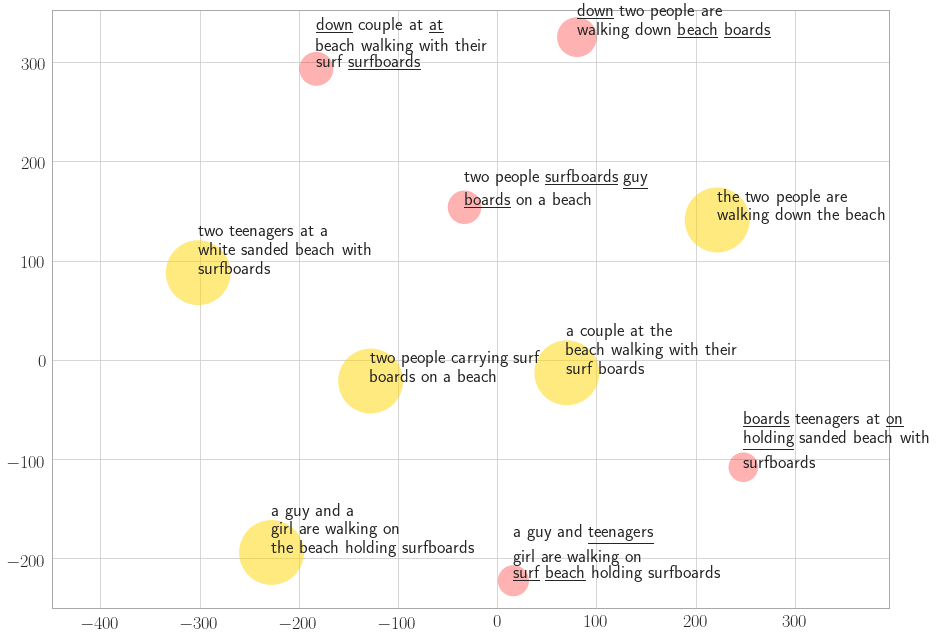

In [51]:

ids = list(caps)
sns.set()
sns.set_style('whitegrid', rc={"axes.edgecolor": 'darkgray'})
sns.set_context('paper', font_scale=2.3, rc={"lines.linewidth": 2,
                                             "lines.markersize": 8})

f, ax = plt.subplots(1, 1, figsize=(15, 11))
plot_sentences(ax, ids[3:4])
# ax.set_xlim([-.8, 2.2])
# ax.set_ylim([-1.2, .9])
# plt.savefig('../figures/sent_bleu.png', dpi=400, bbox_inches='tight')

In [282]:
def hamming(s1, s2):
    assert len(s1) == len(s2)
    return sum(c1 != c2 for c1, c2 in zip(s1, s2))

def plot_sentences_bar(ax, imids, N=2, V="refs", d=3,
                       score="bleu", normalize=1, tauh=.3, taus=.3):
    gts = []
    flatgts = []
    for imid in imids:
        gts.append(caps[imid])
        for c in gts[-1]:
            flatgts.append(c)
    if V=="refs":
        VSUB = []
        for gt in gts:
            v = []
            for g in gt:
                v += g
            v = list(set(v))
            print('Vrefs:', v)
            VSUB.append(v)
    else:
        VSUB = []
        for gt in gts:
            for g in gt:
                VSUB += g
        VSUB = list(set(VSUB))
        print('Vbatch:', VSUB)
        VSUB = len(gts) * [VSUB]
    sampled = []
    flatsampled = []
    altered = []
    for gt, vsub in zip(gts, VSUB):
        ss = []
        aa = []
        for g in gt:
            s, alt = alter(g, d, vsub)
            ss.append(s)
            flatsampled.append(s)
            aa.append(alt)
        sampled.append(ss)
        altered.append(aa)
    SCORES = []
    DSCORES  = []
    for ss, gt in zip(sampled, gts):
        scores = [1] * len(gt)
        dscores = [0] * len(gt)
        for s, g in zip(ss, gt):
            scores.append(sentence_bleu(s, g))
            dscores.append(hamming(s,g))
        if 1:
            scores = [ exp((score-1)/taus) for score in scores]
        if 1:
            dscores = [ exp((-score)/tauh) for score in dscores]
        
        if normalize:
            scores = [s/sum(scores) for s in scores]
            dscores = [s/sum(dscores) for s in dscores]
        
        SCORES.append(scores)
        DSCORES.append(dscores)
    h = .1
    for e, (dscores, scores) in enumerate(zip(DSCORES, SCORES)):
        ys = h/4 * np.arange(2 * len(scores))
        print('ticks:', len(ys), ys)
        print('scores', scores, '\ndscores:', dscores)
        ax.barh(ys[3::4], dscores[:len(gts[e])], height=h/6,
                align='edge', color=COLORS[2], alpha=.7, label='$r_{hamming}$')
        ax.barh(ys[2::4]+h/12, scores[:len(gts[e])], height=h/6,
                align='edge', color=COLORS[1], alpha=.7, label='$r_{bleu}$')
        ax.barh(ys[1::4], dscores[len(gts[e]):], height=h/6,
                align='edge', color=COLORS[2], alpha=.7)
        ax.barh(ys[::4]+h/12, scores[len(gts[e]):], height=h/6,
                align='edge', color=COLORS[1], alpha=.7)
        ticks = []
        for s, g, alt in zip(sampled[e], gts[e], altered[e]):
            ticks.append(r'%s' % ' '.join(highlight(s, alt)))
            ticks.append(r'\textbf {%s}' % ' '.join(g))
        ax.set_yticks(ys[1::2])
        ax.set_yticklabels(ticks)
#         ax.set_xlim([0, 1])
        ax.set_ylim([min(ys), max(ys)+h/4])
        ax.set_xscale("log", nonposx='clip')
        ax.legend(bbox_to_anchor=(.3, -.2), loc=3,
                  ncol=2, borderaxespad=0.)


Vrefs: ['beach', 'guy', 'carrying', 'their', 'and', 'surf', 'boards', 'people', 'couple', 'sanded', 'with', 'down', 'holding', 'are', 'white', 'at', 'two', 'teenagers', 'girl', 'a', 'the', 'surfboards', 'on', 'walking']
ticks: 20 [ 0.     0.025  0.05   0.075  0.1    0.125  0.15   0.175  0.2    0.225
  0.25   0.275  0.3    0.325  0.35   0.375  0.4    0.425  0.45   0.475]
scores [0.17021126477369453, 0.17021126477369453, 0.17021126477369453, 0.17021126477369453, 0.17021126477369453, 0.028813201241269345, 0.028813201241269345, 0.01792028750174305, 0.033348929399724676, 0.04004805674752064] 
dscores: [0.19994184757262629, 0.19994184757262629, 0.19994184757262629, 0.19994184757262629, 0.19994184757262629, 9.077345836378686e-06, 9.077345836378686e-06, 9.077345836378686e-06, 9.077345836378686e-06, 0.00025445275352325585]


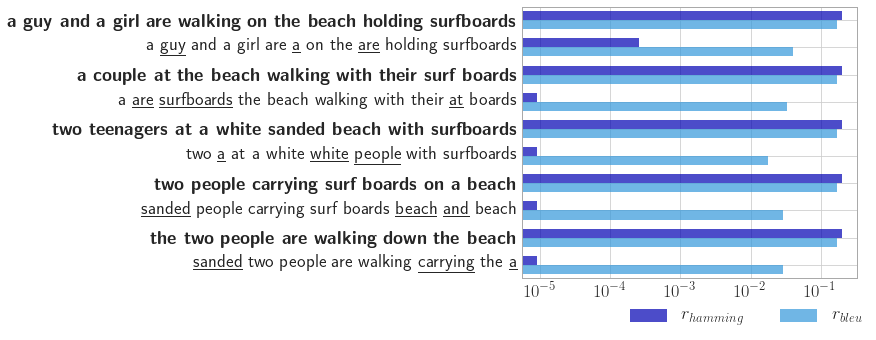

In [286]:

ids = list(caps)
sns.set()
sns.set_style('whitegrid', rc={"axes.edgecolor": 'darkgray'})
sns.set_context('paper', font_scale=2.3, rc={"lines.linewidth": 2,
                                             "lines.markersize": 8})

f, ax = plt.subplots(1, 1, figsize=(6, 5))
plot_sentences_bar(ax, ids[3:4])
# ax.set_xlim([-.8, 2.2])
# ax.set_ylim([-1.2, .9])
# plt.savefig('../figures/sent_bleu.png', dpi=400, bbox_inches='tight')

### Hamming tau

In [302]:
def distrib(m, v, tau=0.7):
    x = [comb(m, d, exact=False) * (v-1)**d / v**m * exp(-d/tau) for d in range(m+1)]
    x = np.array(x)
    x/= np.sum(x)
    return x


In [ ]:
m = 16
V1 = 30
taus1 = [.2, .3, .4]
V2 = 180
taus2= [.15,.17, .2]
V3 = 9800
taus3= [0.09, 0.10, 0.12]
V4 = 300
taus4= [0.13, 0.15, 0.17]
yt = .28
sns.set()
sns.set_style('whitegrid', rc={"axes.edgecolor": 'black'})
sns.set_context('paper', font_scale=2.3, rc={"lines.linewidth": 2,
                                             "lines.markersize": 8})
fig, axs = plt.subplots(2, 2, figsize=(16, 16), sharey=True)
markers = ['*', '^', 'o', 's']
for i, tau in enumerate(taus1):
    axs[0,0].plot(range(m+1) , distrib(m, V1, tau),
                  marker=markers[i],
                  label="$\\tau=%.2f$" % tau)
axs[0,0].legend()
axs[0,0].set_xticks(4 * np.arange(m//4 +1))
axs[0,0].text(.4*m, yt, '$V_{pool}=%d$'% V1)
axs[1,0].set_xlabel('d')

for i, tau in enumerate(taus2):
    axs[0,1].plot(range(m+1),
                  distrib(m, V2, tau),
                  marker=markers[i],
                  label="$\\tau=%.2f$" % tau)
axs[0,1].legend()
axs[0,1].set_xticks(4 * np.arange(m//4 +1))
axs[0,1].text(.4*m, yt, '$V_{pool}=%d$'% V2)
axs[0,1].set_xlabel('d')

for i, tau in enumerate(taus3):
    axs[1,0].plot(range(m+1),
                  distrib(m, V3, tau),
                  marker=markers[i],
                  label="$\\tau=%.2f$" % tau)
axs[1,0].legend()
axs[1,0].set_xticks(4 * np.arange(m//4 +1))
axs[1,0].text(.4*m, yt, '$V_{pool}=%d$'% V3)
axs[1,0].set_xlabel('d')


m = 50
for i, tau in enumerate(taus4):
    axs[1,1].plot(range(m+1),
                  distrib(m, V4, tau),
                  marker=markers[i],
                  label="$\\tau=%.2f$" % tau)
axs[1,1].legend()
axs[1,1].set_xticks(4 * np.arange(m//4 +1))
axs[1,1].text(.4*m, yt, '$V_{pool}=%d$'% V4)
axs[1,1].set_xlabel('d')
plt.tight_layout()

# plt.savefig('../figures/hamming_q.png', dpi=400, bbox_inches='tight')

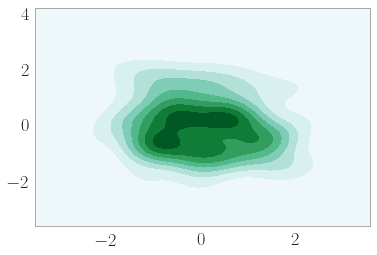

In [45]:
ax = sns.kdeplot(np.random.randn(100), np.random.randn(100), shade=True)

In [86]:
a = [1, 2 , 3, 4]

In [87]:
a[::2]

[1, 3]

In [89]:
a[1::2]

[2, 4]

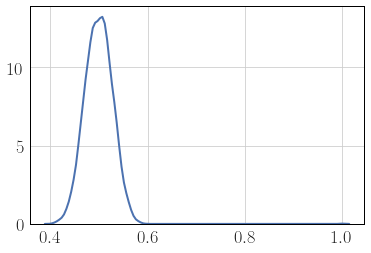

In [306]:
sns.kdeplot(sim_coco[0])